In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('AER_credit_card_data.csv')

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


Create the target variable by mapping `yes` to 1 and `no` to 0. 

In [4]:
df['card'] = [1 if x == 'yes' else 0 for x in df['card']]

In [5]:
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=1)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

# 1

In [8]:
cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [10]:
numerical = [col for col in df_train.columns if df_train[col].dtype == 'int64'or df_train[col].dtype == 'float64' ]
categorical = [col for col in df_train.columns if df_train[col].dtype == "object"]

In [11]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

selected = ["reports", "dependents", "active", "share"]
scores = []
for feature in selected:    
    score = roc_auc_score(y_train, df_train[feature])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[feature])
    scores.append(score)
    print(feature, score)

reports 0.7166629860689376
dependents 0.5327757227773791
active 0.6043173411362006
share 0.989183643423692


In [12]:
print("Answer to question 1 (variable name):", selected[np.where(scores == max(scores))[0][0]])

Answer to question 1 (variable name): share


# 2

In [13]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [14]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [15]:
roc_auc_score(y_val, y_pred)

0.995171242063847

# 3

Now let's compute precision and recall for our model. Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01. For each threshold, compute precision and recall.

At which threshold precision and recall curves intersect?

In [16]:
thresholds = np.arange(0, 1.01, 0.01)

In [17]:
ps = []
rs = []
for t in thresholds:
    preds = (y_pred >= t).astype('int')
    p = precision_score(y_val, preds)
    ps.append(p)
    r = recall_score(y_val, preds)
    rs.append(r)

for indx, p in enumerate(ps):
    if p > rs[indx]:
        print('Answer to question 3 is:', thresholds[indx])
        break

Answer to question 3 is: 0.3


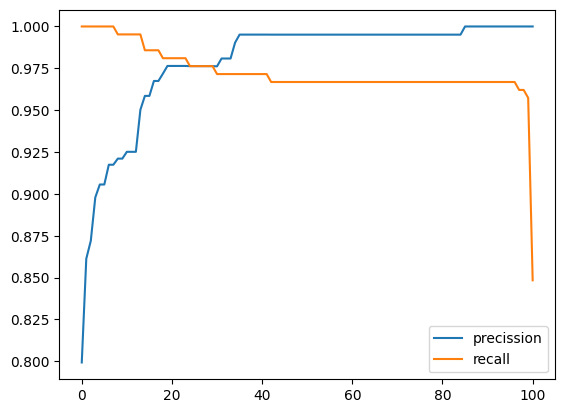

In [18]:
plt.plot(ps, label='precission')
plt.plot(rs, label='recall')
plt.legend()
plt.show()

# 4

Compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set. At which threshold F1 is maximal?

In [19]:
f1s = []
for t in thresholds:
    preds = (y_pred >= t).astype('int')
    p = precision_score(y_val, preds)
    r = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    f1 = 2 * (p * r) / (p + r)
    f1s.append(f1)

In [20]:
answers = [0.1, 0.4, 0.6, 0.7]

In [21]:
indxs = np.where(f1s == max(f1s))[0]

In [22]:
print("Answer to question 4 is:", thresholds[indxs][np.in1d(thresholds[indxs], answers)][0])

Answer to question 4 is: 0.4


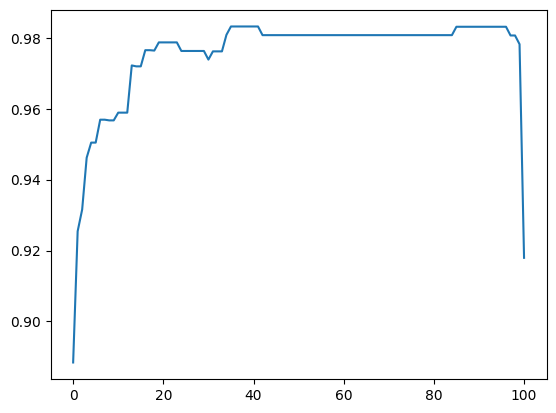

In [23]:
plt.plot(f1s)
plt.show()

# 5

In [24]:
numerical = [col for col in df_train.columns if df_train[col].dtype == 'int64'or df_train[col].dtype == 'float64' ]
categorical = [col for col in df_train.columns if df_train[col].dtype == "object"]

In [25]:
df_train, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=1)

In [26]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [27]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [28]:
from sklearn.model_selection import KFold

In [29]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfold.split(df_train):

    X_train = df_train.iloc[train_idx]
    X_val = df_train.iloc[val_idx]

    y_train = X_train.card.values
    y_val = X_val.card.values

    del X_train['card']
    del X_val['card']

    dv, model = train(X_train, y_train)
    y_pred = predict(X_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    

print('Answer for question 5: %.3f' % np.std(scores))

Answer for question 5: 0.003


# 6

In [30]:
CS = [0.01, 0.1, 1, 10]
scores_mean = []
scores_std = []

for C in CS:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_train):

        X_train = df_train.iloc[train_idx]
        X_val = df_train.iloc[val_idx]

        y_train = X_train.card.values
        y_val = X_val.card.values

        del X_train['card']
        del X_val['card']

        dv, model = train(X_train, y_train, C)
        y_pred = predict(X_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
    scores_mean.append(np.mean(auc))
    scores_std.append(np.std(auc))

In [31]:
indx = np.where(scores_mean == max(scores_mean))[0][0]

In [32]:
print("Answer for question 6:", CS[indx])

Answer for question 6: 10
